In [1]:
# Manipulação de dados
import pandas as pd
import numpy as np

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
from matplotlib.gridspec import GridSpec
import matplotlib.dates as mdates
import matplotlib.colors as mcolors

# Estatística e análise
import scipy.stats as stats
from scipy.stats import fisher_exact, linregress
from itertools import combinations

# Geoprocessamento
import geopandas as gpd
from shapely.geometry import Point
from shapely import wkt
from geobr import read_state

# Machine Learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

# Otimização
from pulp import LpProblem, LpMinimize, LpVariable, lpSum, LpStatus, value

# Conexão com banco de dados
import psycopg2

# Configurações e ajustes
import warnings
import unicodedata
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
# Ocultar warnings
warnings.filterwarnings("ignore")

# Configurações de exibição
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)

import geopandas as gpd
from shapely import wkt


/home/deboragomes/.local/share/virtualenvs/debora-a-xJ3oPA/lib/python3.10/site-packages/geopandas/_compat.py:154: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  set_use_pygeos()
/tmp/ipykernel_46625/3198074477.py:19: DeprecationWarning: GeoPandas is set to use PyGEOS over Shapely. PyGEOS support is deprecatedand will be removed in GeoPandas 1.0, released in the Q1 of 2024. Please migrate to Shapely 2.0 (https://geopandas.org/en/stable/docs/user_guide/pygeos_to_shapely.html).
  import geopandas as gpd


## PARTE 1: CLASSIFICAÇÃO DAS MESORREGIÕES


### I. CÁLCULO DAS TAXAS PARA CADA MESORREGIÃO

Foram calculadas diferentes métricas de desempenho para as mesorregiões com base nos contratos:

- **Taxa de Atendimento:** Proporção de contratos não cancelados em relação ao total de contratos.

- **Taxa de Retenção:** Proporção de clientes retidos (com status "Recorrente" ou "Ativo") em relação ao total de clientes.

- **Taxa de Atuação do Falcon:** Proporção de contratos em que o Falcon atuou.

- **Quantidade de Contratos:** Contagem única de contratos por dia e mesorregião.

Para dar maior relevância aos meses mais recentes, foi aplicado um **ajuste temporal**, multiplicando as taxas e a quantidade de contratos por um peso calculado com base nos dias.


### II. ANÁLISE DE COMPONENTES PRINCIPAIS (PCA)

A Análise de Componentes Principais (PCA) foi utilizada para reduzir a dimensionalidade dos dados, transformando variáveis correlacionadas em componentes principais ortogonais, facilitando a interpretação e a visualização. 

Os três primeiros componentes principais explicam juntos 86,78% da variância total dos dados:

- **Primeiro Componente Principal (PC1):** 
Este componente captura a principal tendência nos dados, sugerindo que altas taxas de atuação do Falcon estão associadas a baixas taxas de retenção e menor volume de contratos.
  
- **Segundo Componente Principal (PC2):** 
Destaca uma relação inversa entre a taxa de atendimento e as outras métricas, indicando que altos níveis de atendimento não necessariamente se traduzem em maior retenção ou contratos.

- **Terceiro Componente Principal (PC3):** 
Pode ser interpretado como um cenário onde um alto atendimento se correlaciona com maior atuação do Falcon, mas sem impacto direto na retenção ou no volume de contratos.

A aplicação do PCA possibilitou uma análise mais clara dos padrões e agrupamentos nas mesorregiões, mantendo a maior parte da variabilidade dos dados.


### III. GRUPOS (CLUSTERS) DE MESORREGIÕES

O método do Cotovelo (Elbow Method) foi utilizado para determinar o número ideal de clusters, definido como 3. 

O algoritmo K-Means foi então aplicado, segmentando as mesorregiões em grupos distintos. As características de cada cluster foram identificadas por meio de um heatmap, permitindo a análise detalhada de cada grupo. 

Os clusters foram nomeados de acordo com as médias das métricas principais:

- **Cluster 0:** "Baixa Retenção, Poucos Contratos, Alto Atendimento" (40 mesorregiões)

- **Cluster 1:** "Alta Retenção, Muitos Contratos, Médio Atendimento" (30 mesorregiões)

- **Cluster 2:** "Alta Atuação Falcon, Risco Operacional" (43 mesorregiões)

Esses nomes estão sujeitos a validação para garantir uma melhor interpretação dos grupos.

### RESULTADO DA PARTE 1

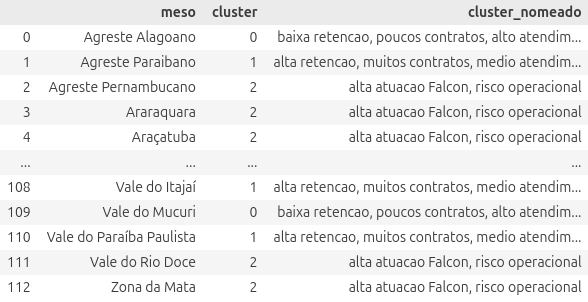

___

## PARTE 2: DIVISÃO DAS MESORREGIÕES 

A função `distribuir_mesoregioes` foi desenvolvida para realizar a distribuição equilibrada das mesorregiões entre dois responsáveis (Donega e Leonardo), considerando:
 - clusters 
 - categorias ("ajudante", "curta", "longa"). 

O objetivo foi minimizar o desvio na distribuição dos contratos, mantendo o equilíbrio em todas as categorias e clusters. Para isso, a quantidade de contratos foi analisada desde julho de 2024, aplicando-se o **ajuste temporal** para dar maior importância aos contratos mais recentes.

A função priorizou os clusters críticos na alocação das mesorregiões e utilizou uma lógica de desvio mínimo para definir o responsável (Donega ou Leonardo) com base na **menor diferença de contratos por categoria**. 

Os resultados mostraram uma diferença mínima nos contratos alocados entre Donega e Leonardo, comprovando a eficácia da função em distribuir as mesorregiões de forma justa e equilibrada, mantendo o foco nos clusters críticos e otimizando o balanceamento operacional.

### RESULTADO DA PARTE 2

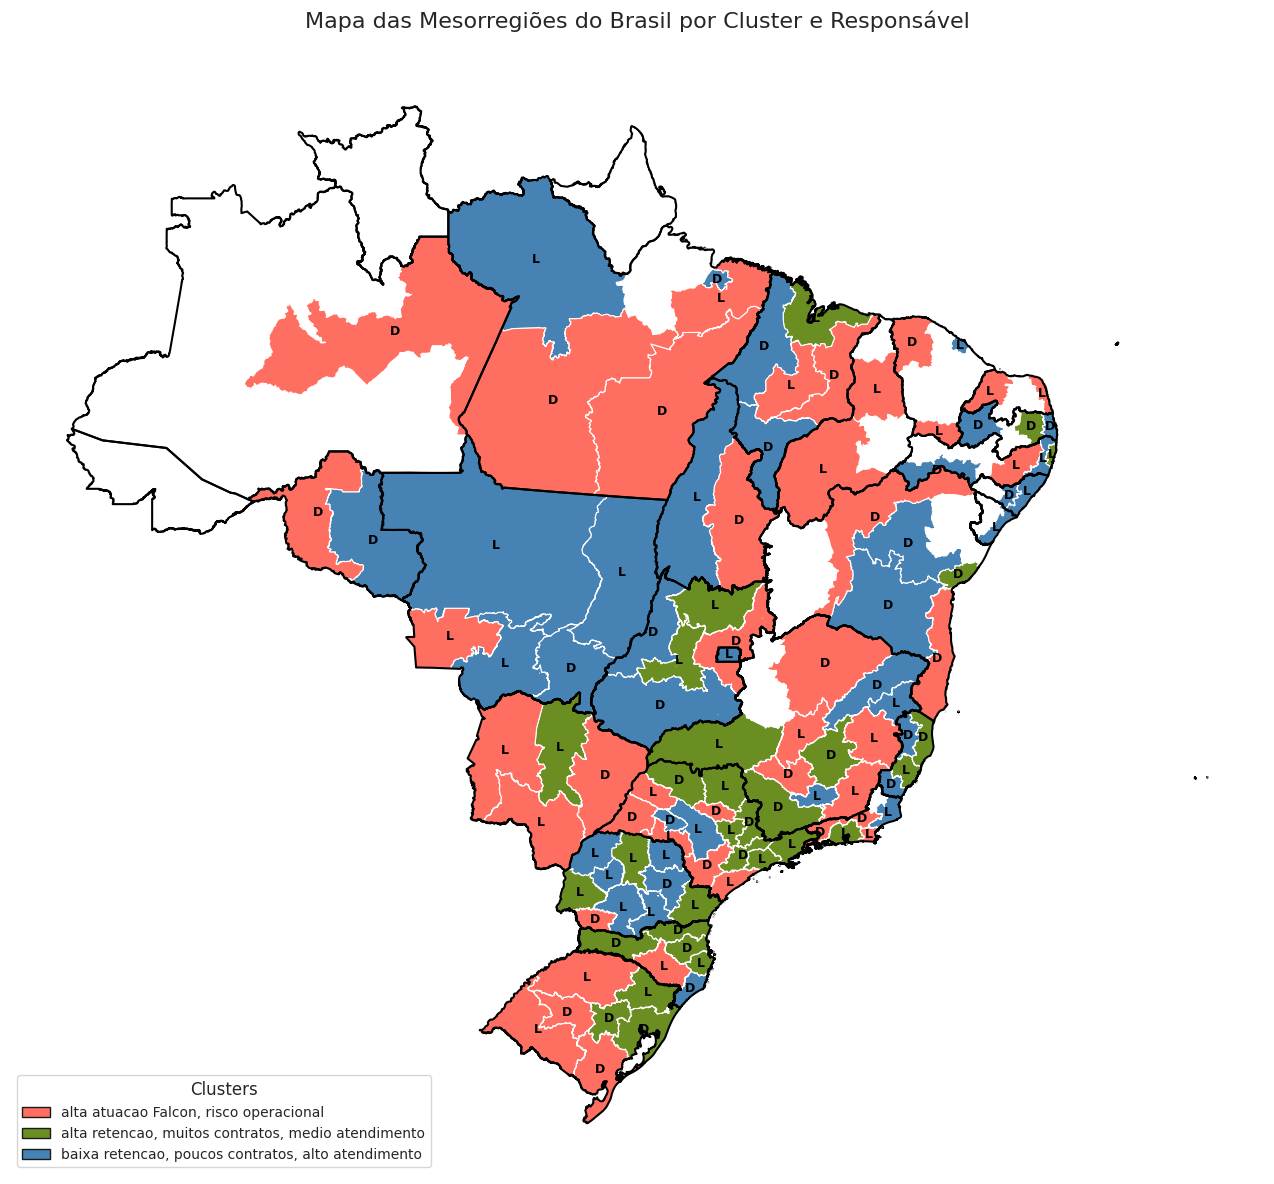

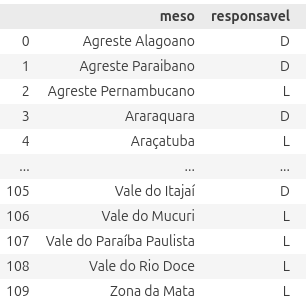

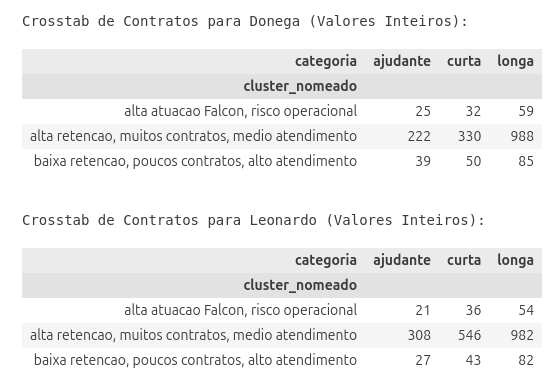

# CONTRATOS

In [2]:
# contratos
conn = psycopg2.connect(
    dbname="px",
    user="debora_gomes",
    password="hT817qrR5uf41xh7Vlh5T",
    host="localhost",
    port="43561",
)
cursor = conn.cursor()

cursor.execute(f"""

    SELECT 
        f.type,
        public.freights_type(f.type) AS type_descricao,
        CASE
            WHEN f.type::INTEGER = 2 THEN 'ajudante'
            WHEN f.type::INTEGER = 3 THEN 'curta'
            ELSE 'longa'
        END AS categoria, 
        f.status,
        public.freights_status(f.status) AS status_descricao,
        CASE 
            WHEN f.status = 900 THEN 'sim'
            ELSE 'nao'
        END AS foi_cancelada, 
        f.start_at AS dia,
        f.id AS freight_id,
        f.price / 100 AS price,
        f.contract_days,
        f.company_id,
        ca.latitude AS origin_latitude,
        ca.longitude AS origin_longitude,
        CASE 
            WHEN uwf.freight_id IS NOT NULL THEN 'sim'
            ELSE 'nao'
        END AS atuacao_falcon,
        c.created_at AS company_created_at,
        c.updated_at AS company_updated_at,
        c.client_status AS company_status,
        public.companies_client_status(c.client_status) AS company_descricao,
        c.status_changed_at AS company_status_changed_at
    FROM freights f
    LEFT JOIN company_addresses ca ON ca.id = f.origin
    LEFT JOIN (
        SELECT DISTINCT freight_id
        FROM user_working_freights
    ) uwf ON uwf.freight_id = f.id
    LEFT JOIN companies c ON c.id = f.company_id
    WHERE f.start_at >= '2024-07-01'
      AND f.start_at < CURRENT_DATE
      AND f.company_id NOT IN (
          SELECT id 
          FROM companies 
          WHERE company_multitenancy_id = 5
      )
    ORDER BY f.start_at ASC;
""")


contratos = cursor.fetchall()
colnames = [desc[0] for desc in cursor.description]
contratos = pd.DataFrame(contratos, columns=colnames)

cursor.close()
conn.close()

contratos['mes'] = pd.to_datetime(contratos['dia']).dt.to_period('M').dt.to_timestamp()
contratos["dia"] = contratos["dia"].dt.date
contratos["dia"] = pd.to_datetime(contratos["dia"])

# ibge_meso - Mesoregioes
ibge_meso = gpd.read_file("BR_Mesorregioes_2022/BR_Mesorregioes_2022.shp").rename(columns={'NM_MESO': 'meso', 'SIGLA_UF': 'estado', 'geometry': 'geometry_meso'})
ibge_meso = ibge_meso[['meso', 'geometry_meso', 'estado']]
ibge_meso = ibge_meso.set_geometry('geometry_meso') 
ibge_meso = ibge_meso.to_crs(epsg=4326)

contratos["geometry_meso"] = contratos.apply(lambda row: Point(row["origin_longitude"], row["origin_latitude"]), axis=1)
gdf_contratos = gpd.GeoDataFrame(contratos, geometry="geometry_meso", crs="EPSG:4326") 
ibge = ibge_meso.to_crs(gdf_contratos.crs)
contratos = gpd.sjoin(gdf_contratos, ibge_meso, predicate="within", how="left")

contratos = contratos[['mes', 'dia','categoria', 'foi_cancelada', 'atuacao_falcon', 'company_descricao','freight_id', 'price','contract_days','company_id','meso', 'estado']]

contratos = contratos.loc[contratos.mes < '2025-03-01']
contratos.to_csv('contratos.csv', index=False)
contratos

,mes,dia,categoria,foi_cancelada,atuacao_falcon,company_descricao,freight_id,price,contract_days,company_id,meso,estado
0,2024-07-01,2024-07-01,ajudante,sim,nao,Inativo,90890,1500,3,2426,Metropolitana de Porto Alegre,RS
1,2024-07-01,2024-07-01,ajudante,sim,nao,Inativo,90877,1500,3,2426,Metropolitana de Porto Alegre,RS
2,2024-07-01,2024-07-01,ajudante,sim,nao,Inativo,90892,1500,3,2426,Metropolitana de Porto Alegre,RS
3,2024-07-01,2024-07-01,longa,nao,nao,Ativo,89871,5320,19,2843,Norte Central Paranaense,PR
4,2024-07-01,2024-07-01,longa,nao,nao,Ativo,90971,1400,5,704,Metropolitana de São Paulo,SP
...,...,...,...,...,...,...,...,...,...,...,...,...
47025,2025-02-01,2025-02-28,longa,nao,nao,Ativo,146020,3720,10,2102,Macro Metropolitana Paulista,SP
47026,2025-02-01,2025-02-28,longa,nao,nao,Ativo,145986,3720,10,2102,Macro Metropolitana Paulista,SP
47027,2025-02-01,2025-02-28,longa,nao,nao,Ativo,146022,3720,10,2102,Macro Metropolitana Paulista,SP
47028,2025-02-01,2025-02-28,longa,nao,nao,Ativo,146004,3720,10,2102,Macro Metropolitana Paulista,SP


# TAXAS

In [3]:
# taxas

# taxa_atendimento
taxa_atendimento = (
    contratos.groupby(['mes', 'meso','dia', ])['foi_cancelada']
    .apply(lambda x: (x == 'nao').sum() / x.count())
    .reset_index(name='taxa_atendimento'))

# taxa_retencao
status_continua = ["Recorrente", "Ativo"]
contratos['cliente_retido'] = contratos['company_descricao'].isin(status_continua)

taxa_retencao = contratos.groupby(['meso', 'mes', 'dia']).agg(
    total_clientes=('company_id', 'nunique'),
    clientes_retidos=('cliente_retido', 'sum')
).reset_index()

taxa_retencao['taxa_retencao'] = taxa_retencao['clientes_retidos'] / taxa_retencao['total_clientes']
taxa_retencao = taxa_retencao[['mes','dia', 'meso',  'taxa_retencao']]

# taxa_falcon
taxa_falcon = (
    contratos.groupby(['mes', 'meso','dia'])['atuacao_falcon']
    .apply(lambda x: (x == 'sim').sum() / x.count())
    .reset_index(name='taxa_falcon'))

contagem_mensal = contratos.groupby(['mes', 'meso','dia']).agg(qt_contratos=('freight_id', 'nunique'),).reset_index()

# taxas
taxas = taxa_atendimento.merge(taxa_retencao , on=[ 'mes','dia','meso'], how='left')
taxas = taxas.merge(taxa_falcon , on=[ 'mes','dia','meso'], how='left')
taxas = taxas.merge(contagem_mensal , on=[ 'mes','dia','meso'], how='left')

taxas.head(3)

,mes,meso,dia,taxa_atendimento,taxa_retencao,taxa_falcon,qt_contratos
0,2024-07-01,Agreste Pernambucano,2024-07-04,1.00,0.00,0.00,2
1,2024-07-01,Agreste Pernambucano,2024-07-09,0.00,0.00,1.00,1
2,2024-07-01,Agreste Pernambucano,2024-07-10,1.00,0.00,0.00,1


In [4]:
# taxas_ajustadas

taxas_ajustadas = taxas

# Criar um peso temporal, onde os meses mais recentes têm peso maior
taxas_ajustadas['peso_tempo'] = (taxas_ajustadas['dia'] - taxas_ajustadas['dia'].min()).dt.days
taxas_ajustadas['peso_tempo'] = taxas_ajustadas['peso_tempo'] / taxas_ajustadas['peso_tempo'].max()

taxas_ajustadas['taxa_atendimento_aj'] = taxas_ajustadas['taxa_atendimento'] * (1 + taxas_ajustadas['peso_tempo'])
taxas_ajustadas['taxa_retencao_aj'] = taxas_ajustadas['taxa_retencao'] * (1 + taxas_ajustadas['peso_tempo'])
taxas_ajustadas['taxa_falcon_aj'] = taxas_ajustadas['taxa_falcon'] * (1 + taxas_ajustadas['peso_tempo'])

taxas_ajustadas['qt_contratos_aj'] = taxas_ajustadas['qt_contratos'] * (1 + taxas_ajustadas['peso_tempo'])

# all = all.drop(columns=["taxa_atendimento", 'dia',"taxa_retencao", "qt_contratos", "price", "peso_tempo"], inplace=False)
taxas_ajustadas = taxas_ajustadas.sort_values(["meso", "mes"]) 
taxas_ajustadas = taxas_ajustadas.groupby(["meso"]).apply(lambda x: x.iloc[1:]).reset_index(drop=True)  # Remover a primeira linha de cada grupo
taxas_ajustadas.head(3)

,mes,meso,dia,taxa_atendimento,taxa_retencao,taxa_falcon,qt_contratos,peso_tempo,taxa_atendimento_aj,taxa_retencao_aj,taxa_falcon_aj,qt_contratos_aj
0,2024-11-01,Agreste Alagoano,2024-11-25,1.00,1.00,0.00,1,0.61,1.61,1.61,0.00,1.61
1,2024-11-01,Agreste Alagoano,2024-11-26,0.00,1.00,0.40,5,0.61,0.00,1.61,0.64,8.06
2,2024-12-01,Agreste Alagoano,2024-12-02,0.25,4.00,0.75,4,0.64,0.41,6.55,1.23,6.55


In [5]:
# taxas_medias

taxas_medias = taxas_ajustadas.groupby(["mes", "meso"], as_index=False).agg({
    "taxa_atendimento_aj": "mean",
    "taxa_retencao_aj": "mean",
    "taxa_falcon_aj": "mean",
     "qt_contratos_aj": "sum",
  #  "price": "sum"
}).rename(columns={
    "taxa_atendimento_aj": "taxa_atendimento_mean",
    "taxa_retencao_aj": "taxa_retencao_mean",
    "taxa_falcon": "taxa_falcon_mean",
   "qt_contratos_aj": "sum_contratos",
  #  "price": "sum_price"
})

#taxas_medias["participacao_categoria"] = taxas_medias.groupby("meso")["sum_contratos"].transform(lambda x: x / x.sum())

taxas_medias.head(3)

,mes,meso,taxa_atendimento_mean,taxa_retencao_mean,taxa_falcon_aj,sum_contratos
0,2024-07-01,Agreste Pernambucano,0.70,0.00,0.70,3.13
1,2024-07-01,Araçatuba,0.94,0.40,0.41,11.63
2,2024-07-01,Assis,1.07,0.00,1.07,1.07


In [6]:
# media

media = taxas_medias.groupby(["meso"], as_index=False).agg({
    "taxa_atendimento_mean": "mean",
    "taxa_retencao_mean": "mean",
    "taxa_falcon_aj": "mean",
    "sum_contratos": "mean",
}).rename(columns={
    "taxa_atendimento_mean": "taxa_atendimento_media",
    "taxa_retencao_mean": "taxa_retencao_media",
    "taxa_falcon_aj": "taxa_falcon_media",
    "sum_contratos": "contratos_media",

})

# Calcular a participação percentual de cada categoria dentro de cada mesorregião
# media["participacao_categoria"] = media.groupby("meso")["contratos_media"].transform(lambda x: x / x.sum())

media.head(3)

,meso,taxa_atendimento_media,taxa_retencao_media,taxa_falcon_media,contratos_media
0,Agreste Alagoano,1.23,2.71,0.23,12.26
1,Agreste Paraibano,0.84,4.71,0.59,30.13
2,Agreste Pernambucano,0.95,0.13,0.63,5.67


# PCA

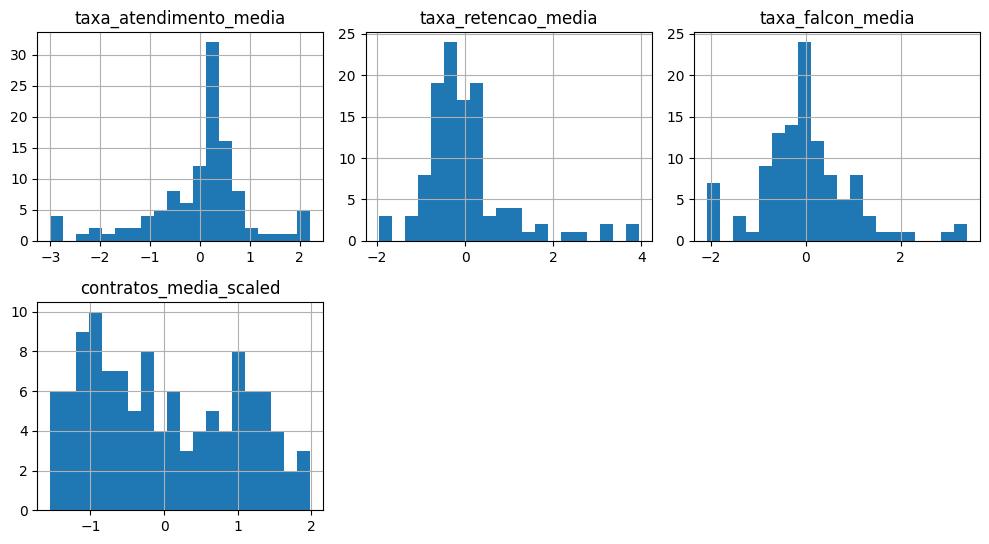

Variância explicada por componente: [0.43734108 0.22574074 0.20721287]


In [7]:
# pca
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, PowerTransformer

df = media

# Aplicar o Power Transformer apenas na coluna 'contratos_media'
pt = PowerTransformer(method='yeo-johnson')
df['contratos_media_yeo'] = pt.fit_transform(df[['contratos_media']])

# Selecionar as colunas para padronização
columns_to_scale = ['taxa_atendimento_media', 'taxa_retencao_media', 'taxa_falcon_media']

# Padronizar as colunas selecionadas
scaler = StandardScaler()
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

# Incluir a coluna transformada de 'contratos_media' no conjunto padronizado
df['contratos_media_scaled'] = df['contratos_media_yeo']

# Visualizar as distribuições após as transformações
columns_to_plot = ['taxa_atendimento_media', 'taxa_retencao_media', 'taxa_falcon_media','contratos_media_scaled']

plt.figure(figsize=(10, 8))
for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(3, 3, i)
    plt.hist(df[column], bins=20)
    plt.title(column)
    plt.grid(True)

plt.tight_layout()
plt.show()

# Aplicar o PCA com as colunas padronizadas e transformadas
columns_for_pca = ['taxa_atendimento_media', 'taxa_retencao_media', 'taxa_falcon_media',
                   'contratos_media_scaled']

pca = PCA(n_components=3)
df_pca = pca.fit_transform(df[columns_for_pca])

# Adicionar os componentes principais ao DataFrame
df_pca = pd.DataFrame(df_pca, columns=['PCA1', 'PCA2', 'PCA3'])
df_pca['meso'] = df['meso']

# Exibir a variância explicada por cada componente
print('Variância explicada por componente:', pca.explained_variance_ratio_)


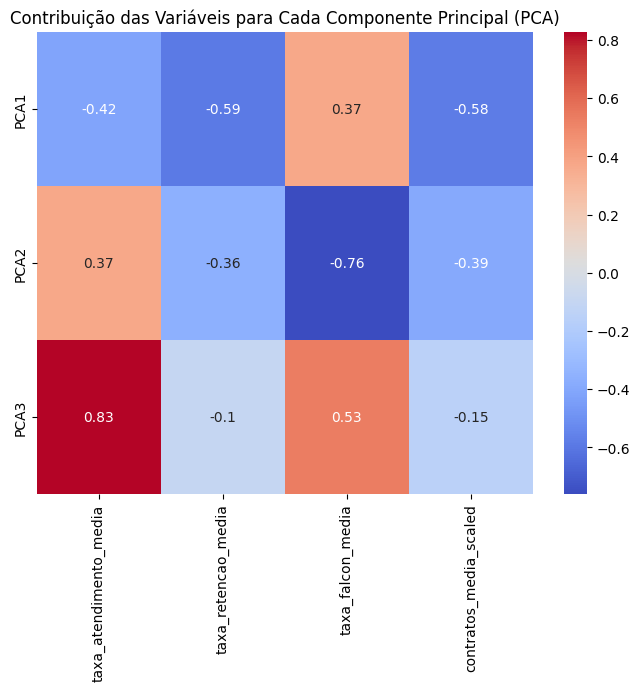

In [8]:
# Exibir os componentes principais e os pesos das variáveis
pca_components = pd.DataFrame(pca.components_, 
                              columns=columns_for_pca, 
                              index=[f'PCA{i+1}' for i in range(pca.n_components_)])

plt.figure(figsize=(8, 6))
sns.heatmap(pca_components, cmap='coolwarm', annot=True)
plt.title('Contribuição das Variáveis para Cada Componente Principal (PCA)')
plt.show()

#  CLUSTERIZAÇÃO DAS MESOREGIÕES

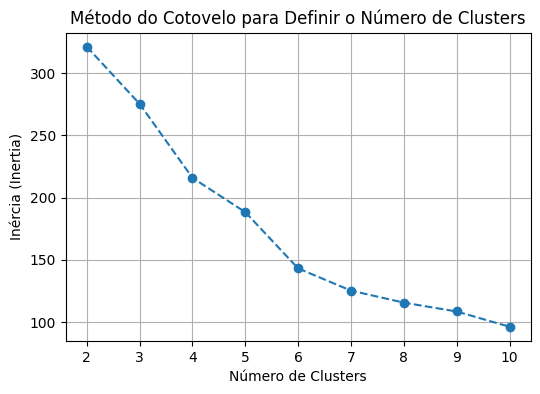

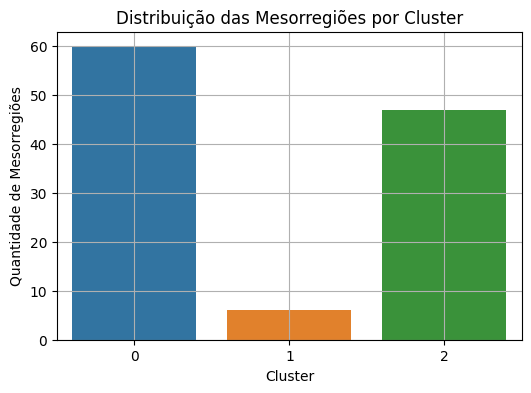

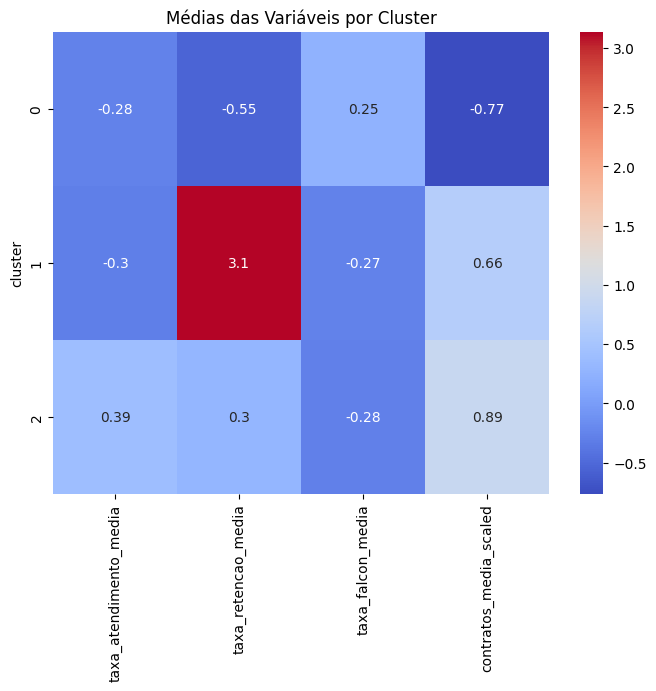

In [9]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

columns_for_clustering = ['taxa_atendimento_media', 'taxa_retencao_media', 'taxa_falcon_media','contratos_media_scaled']

X = df[columns_for_clustering]

# Método do Cotovelo (Elbow Method)
inertia = []
silhouette_scores = []
range_clusters = range(2, 11)

for n_clusters in range_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X, kmeans.labels_))

# Plotar o método do cotovelo
plt.figure(figsize=(6, 4))
plt.plot(range_clusters, inertia, marker='o', linestyle='--')
plt.xlabel('Número de Clusters')
plt.ylabel('Inércia (Inertia)')
plt.title('Método do Cotovelo para Definir o Número de Clusters')
plt.grid(True)
plt.show()


# Aplicar o K-Means com o número ideal de clusters (ex.: 3 clusters)
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(X)

# Visualizar a composição dos clusters
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='cluster', palette='tab10')
plt.xlabel('Cluster')
plt.ylabel('Quantidade de Mesorregiões')
plt.title('Distribuição das Mesorregiões por Cluster')
plt.grid(True)
plt.show()

# Visualizar as médias das variáveis em cada cluster
cluster_means = df.groupby('cluster')[columns_for_clustering].mean()
plt.figure(figsize=(8, 6))
sns.heatmap(cluster_means, cmap='coolwarm', annot=True)
plt.title('Médias das Variáveis por Cluster')
plt.show()

In [10]:
# cluster_meso

# Calcular a média das métricas principais por cluster
cluster_means = df.groupby('cluster')[['taxa_falcon_media', 'taxa_retencao_media', 'contratos_media_scaled', 'taxa_atendimento_media']].mean()

# Ordenar os clusters dinamicamente com base nas métricas principais
cluster_order = cluster_means.sort_values(by='taxa_falcon_media').index

# Mapear os clusters para os nomes corretos com base na ordem das métricas
cluster_names = {
    cluster_order[0]: "baixa retencao, poucos contratos, alto atendimento",
    cluster_order[1]: "alta retencao, muitos contratos, medio atendimento",
    cluster_order[2]: "alta atuacao Falcon, risco operacional"
}

# Aplicar os nomes dinamicamente aos clusters
df['cluster_nomeado'] = df['cluster'].map(cluster_names)

# Exibir a contagem de mesorregiões por cluster nomeado
print(df['cluster_nomeado'].value_counts())

clusters_meso = df[['meso', 'taxa_atendimento_media', 'taxa_retencao_media',
       'taxa_falcon_media', 'contratos_media','cluster', 'cluster_nomeado']]

clusters_meso = clusters_meso[['meso', 'cluster', 'cluster_nomeado']]
clusters_meso.head(3)


cluster_nomeado
alta atuacao Falcon, risco operacional                60
baixa retencao, poucos contratos, alto atendimento    47
alta retencao, muitos contratos, medio atendimento     6
Name: count, dtype: int64


,meso,cluster,cluster_nomeado
0,Agreste Alagoano,2,"baixa retencao, poucos contratos, alto atendim..."
1,Agreste Paraibano,1,"alta retencao, muitos contratos, medio atendim..."
2,Agreste Pernambucano,0,"alta atuacao Falcon, risco operacional"


# CONTRATOS_FALCON

In [11]:
# falcon

contratos_falcon = contratos.loc[contratos.atuacao_falcon == 'sim']

# total_falcon
contagem_mensal = contratos_falcon.groupby(['mes','dia','categoria', 'meso']).agg(qt_contratos=('freight_id', 'nunique'),).reset_index()
#dias_agenciados_mensal = contratos_falcon.groupby(['mes','dia','categoria', 'meso']).agg(dias_agenciados=('contract_days', 'sum'),).reset_index()
price_mensal = contratos_falcon.groupby(['mes','dia','categoria', 'meso']).agg(price =('price', 'sum'),).reset_index()
falcon = contagem_mensal.merge(price_mensal, on=['mes','dia', 'categoria', 'meso'], how='left').fillna(0)
falcon.head(3)

,mes,dia,categoria,meso,qt_contratos,price
0,2024-07-01,2024-07-03,ajudante,Metropolitana de São Paulo,1,150
1,2024-07-01,2024-07-03,longa,Campinas,1,560
2,2024-07-01,2024-07-03,longa,Macro Metropolitana Paulista,2,1026


In [12]:
# falcon_ajustado

falcon_ajustado = falcon

# Criar um peso temporal, onde os meses mais recentes têm peso maior
falcon_ajustado['peso_tempo'] = (falcon_ajustado['dia'] - falcon_ajustado['dia'].min()).dt.days
falcon_ajustado['peso_tempo'] = falcon_ajustado['peso_tempo'] / falcon_ajustado['peso_tempo'].max()

falcon_ajustado['qt_contratos_aj'] = falcon_ajustado['qt_contratos'] * (1 + falcon_ajustado['peso_tempo'])
falcon_ajustado['price_aj'] = falcon_ajustado['price'] * (1 + falcon_ajustado['peso_tempo'])

falcon_ajustado = falcon_ajustado.sort_values(["meso", "mes"]) 

falcon_ajustado.head(3)

,mes,dia,categoria,meso,qt_contratos,price,peso_tempo,qt_contratos_aj,price_aj
4218,2024-11-01,2024-11-26,ajudante,Agreste Alagoano,1,340,0.61,1.61,546.83
4227,2024-11-01,2024-11-26,curta,Agreste Alagoano,1,1760,0.61,1.61,2830.67
4450,2024-12-01,2024-12-02,ajudante,Agreste Alagoano,3,7060,0.63,4.90,11531.33


In [13]:
# falcon_mensal

falcon_mensal = falcon_ajustado.groupby(["mes", "meso", 'categoria'], as_index=False).agg({
     "qt_contratos_aj": "sum",
     "price_aj": 'sum',
}).rename(columns={
   "qt_contratos_aj": "sum_contratos",
   "price_aj": 'sum_price',
})


falcon_mensal.head(3)

,mes,meso,categoria,sum_contratos,sum_price
0,2024-07-01,Agreste Pernambucano,curta,1.05,462.00
1,2024-07-01,Agreste Pernambucano,longa,1.02,1230.00
2,2024-07-01,Araçatuba,curta,3.14,10110.42


In [14]:
# falcon_meso

falcon_meso = falcon_mensal.groupby(["meso", 'categoria'], as_index=False).agg({
    "sum_contratos": "mean",
    "sum_price": "mean",
}).rename(columns={
    "sum_contratos": "media_contratos",
    "sum_price": "media_price",
})

# Calcular a participação percentual de cada categoria dentro de cada mesorregião
# media["participacao_categoria"] = media.groupby("meso")["contratos_media"].transform(lambda x: x / x.sum())

falcon_meso.head(3)

,meso,categoria,media_contratos,media_price
0,Agreste Alagoano,ajudante,4.08,9149.71
1,Agreste Alagoano,curta,1.61,2830.67
2,Agreste Paraibano,ajudante,8.52,1581.50


#  BASE PARA DIVISÃO

In [15]:
# base_divisao

base_divisao = pd.merge(falcon_meso, clusters_meso, on='meso', how='left')
base_divisao = pd.merge(base_divisao, ibge_meso, on='meso', how='left')

base_divisao.to_csv('base_divisao.csv', index=False)
base_divisao.head(3)

,meso,categoria,media_contratos,media_price,cluster,cluster_nomeado,geometry_meso,estado
0,Agreste Alagoano,ajudante,4.08,9149.71,2.00,"baixa retencao, poucos contratos, alto atendim...","POLYGON ((-36.38936 -9.42538, -36.33942 -9.464...",AL
1,Agreste Alagoano,curta,1.61,2830.67,2.00,"baixa retencao, poucos contratos, alto atendim...","POLYGON ((-36.38936 -9.42538, -36.33942 -9.464...",AL
2,Agreste Paraibano,ajudante,8.52,1581.50,1.00,"alta retencao, muitos contratos, medio atendim...","POLYGON ((-35.42241 -7.27272, -35.42200 -7.272...",PB


# distribuir_mesorregioes

In [44]:
# Função para distribuir mesorregiões de forma equilibrada considerando todas as categorias e clusters
def distribuir_mesoregioes(base_divisao):
    print("Colunas disponíveis no DataFrame:", base_divisao.columns)
    
    # Remover a coluna 'responsavel' existente, se houver
    if 'responsavel' in base_divisao.columns:
        base_divisao = base_divisao.drop(columns=['responsavel'])

    # Calcular a soma total por mesorregião, categoria e cluster
    df_meso_total = base_divisao.groupby(['meso', 'categoria', 'cluster_nomeado'])['media_contratos'].sum().reset_index()
    
    # Priorizar a distribuição dos clusters na ordem desejada
    cluster_prioridade = [
        'alta atuacao Falcon, risco operacional',
        'alta retencao, muitos contratos, medio atendimento',
        'baixa retencao, poucos contratos, alto atendimento'
    ]
    df_meso_total['cluster_prioridade'] = df_meso_total['cluster_nomeado'].map(lambda x: cluster_prioridade.index(x))
    df_meso_total = df_meso_total.sort_values(by=['cluster_prioridade', 'media_contratos'], ascending=[True, False])

    # Inicializar variáveis para distribuição equilibrada dinamicamente
    distribuicao = []
    soma_donega = {'ajudante': 0, 'curta': 0, 'longa': 0}
    soma_leonardo = {'ajudante': 0, 'curta': 0, 'longa': 0}
    meso_responsavel = {}

    # Distribuir mesorregiões priorizando clusters críticos
    for _, row in df_meso_total.iterrows():
        meso = row['meso']
        categoria = row['categoria']
        cluster = row['cluster_nomeado']
        total_contratos = row['media_contratos']

        # Se a mesorregião já tem um responsável atribuído, manter o mesmo responsável
        if meso in meso_responsavel:
            responsavel = meso_responsavel[meso]
        else:
            # Calcular o desvio considerando o equilíbrio das categorias
            desvio_donega = abs((soma_donega[categoria] + total_contratos) - soma_leonardo[categoria])
            desvio_leonardo = abs((soma_leonardo[categoria] + total_contratos) - soma_donega[categoria])

            # Escolher o responsável que minimiza o desvio
            if desvio_donega <= desvio_leonardo:
                responsavel = 'D'
                soma_donega[categoria] += total_contratos
            else:
                responsavel = 'L'
                soma_leonardo[categoria] += total_contratos
            
            # Atribuir o responsável fixo para a mesorregião
            meso_responsavel[meso] = responsavel

        distribuicao.append({
            'meso': meso, 
            'responsavel': responsavel, 
            'cluster_nomeado': cluster, 
            'categoria': categoria, 
            'media_contratos': total_contratos
        })

    # Criar DataFrame com a nova distribuição e manter todas as linhas
    df_distribuicao_final = pd.DataFrame(distribuicao)

    # Ordenar o DataFrame final pelo nome da mesorregião
    df_distribuicao_final = df_distribuicao_final.sort_values(by='meso')

    # Criar crosstabs separados para Donega e Leonardo com valores inteiros
    crosstab_donega = df_distribuicao_final[df_distribuicao_final['responsavel'] == 'D'].pivot_table(
        index='cluster_nomeado', 
        columns='categoria', 
        values='media_contratos', 
        aggfunc='sum', 
        fill_value=0
    ).round().astype(int)

    crosstab_leonardo = df_distribuicao_final[df_distribuicao_final['responsavel'] == 'L'].pivot_table(
        index='cluster_nomeado', 
        columns='categoria', 
        values='media_contratos', 
        aggfunc='sum', 
        fill_value=0
    ).round().astype(int)

    # Exibir os resultados
    print('\nDistribuição Equilibrada das Mesorregiões (Garantindo Responsável Único por Meso):')
    display(df_distribuicao_final)
    print('\nCrosstab de Contratos para Donega (Valores Inteiros):')
    display(crosstab_donega)
    print('\nCrosstab de Contratos para Leonardo (Valores Inteiros):')
    display(crosstab_leonardo)

    return df_distribuicao_final, crosstab_donega, crosstab_leonardo

# Executar a função com a base fornecida
distribuindo, crosstab_donega, crosstab_leonardo = distribuir_mesoregioes(base_divisao)


Colunas disponíveis no DataFrame: Index(['meso', 'categoria', 'media_contratos', 'media_price', 'cluster',
       'cluster_nomeado', 'geometry_meso', 'estado'],
      dtype='object')

Distribuição Equilibrada das Mesorregiões (Garantindo Responsável Único por Meso):


,meso,responsavel,cluster_nomeado,categoria,media_contratos
214,Agreste Alagoano,L,"baixa retencao, poucos contratos, alto atendim...",ajudante,4.08
241,Agreste Alagoano,L,"baixa retencao, poucos contratos, alto atendim...",curta,1.61
118,Agreste Paraibano,L,"alta retencao, muitos contratos, medio atendim...",longa,1.40
113,Agreste Paraibano,L,"alta retencao, muitos contratos, medio atendim...",curta,8.19
111,Agreste Paraibano,L,"alta retencao, muitos contratos, medio atendim...",ajudante,8.52
...,...,...,...,...,...
217,Vale do Rio Doce,L,"baixa retencao, poucos contratos, alto atendim...",ajudante,3.73
186,Vale do Rio Doce,L,"baixa retencao, poucos contratos, alto atendim...",longa,7.90
220,Zona da Mata,L,"baixa retencao, poucos contratos, alto atendim...",curta,3.44
192,Zona da Mata,L,"baixa retencao, poucos contratos, alto atendim...",longa,7.32



Crosstab de Contratos para Donega (Valores Inteiros):


categoria,ajudante,curta,longa
cluster_nomeado,,,
"alta atuacao Falcon, risco operacional",18,39,68
"alta retencao, muitos contratos, medio atendimento",41,37,83
"baixa retencao, poucos contratos, alto atendimento",182,325,962



Crosstab de Contratos para Leonardo (Valores Inteiros):


categoria,ajudante,curta,longa
cluster_nomeado,,,
"alta atuacao Falcon, risco operacional",30,40,66
"alta retencao, muitos contratos, medio atendimento",9,10,18
"baixa retencao, poucos contratos, alto atendimento",363,587,1053


In [45]:
resumo_distribuindo = distribuindo[['meso','responsavel', 'cluster_nomeado']].drop_duplicates()

grafico_divisao = pd.merge(resumo_distribuindo, ibge_meso, on='meso', how='left')
grafico_divisao

,meso,responsavel,cluster_nomeado,geometry_meso,estado
0,Agreste Alagoano,L,"baixa retencao, poucos contratos, alto atendim...","POLYGON ((-36.38936 -9.42538, -36.33942 -9.464...",AL
1,Agreste Paraibano,L,"alta retencao, muitos contratos, medio atendim...","POLYGON ((-35.42241 -7.27272, -35.42200 -7.272...",PB
2,Agreste Pernambucano,L,"alta atuacao Falcon, risco operacional","POLYGON ((-35.57736 -8.43106, -35.57720 -8.430...",PE
3,Araraquara,L,"alta atuacao Falcon, risco operacional","POLYGON ((-48.44486 -22.06315, -48.44547 -22.0...",SP
4,Araçatuba,D,"alta atuacao Falcon, risco operacional","POLYGON ((-50.60958 -21.65693, -50.61028 -21.6...",SP
...,...,...,...,...,...
105,Vale do Itajaí,L,"baixa retencao, poucos contratos, alto atendim...","MULTIPOLYGON (((-49.22314 -26.62051, -49.21892...",SC
106,Vale do Mucuri,D,"alta atuacao Falcon, risco operacional","POLYGON ((-41.36360 -18.27191, -41.36527 -18.2...",MG
107,Vale do Paraíba Paulista,D,"baixa retencao, poucos contratos, alto atendim...","MULTIPOLYGON (((-45.70464 -24.09399, -45.70478...",SP
108,Vale do Rio Doce,L,"baixa retencao, poucos contratos, alto atendim...","POLYGON ((-42.23596 -19.92573, -42.23600 -19.9...",MG


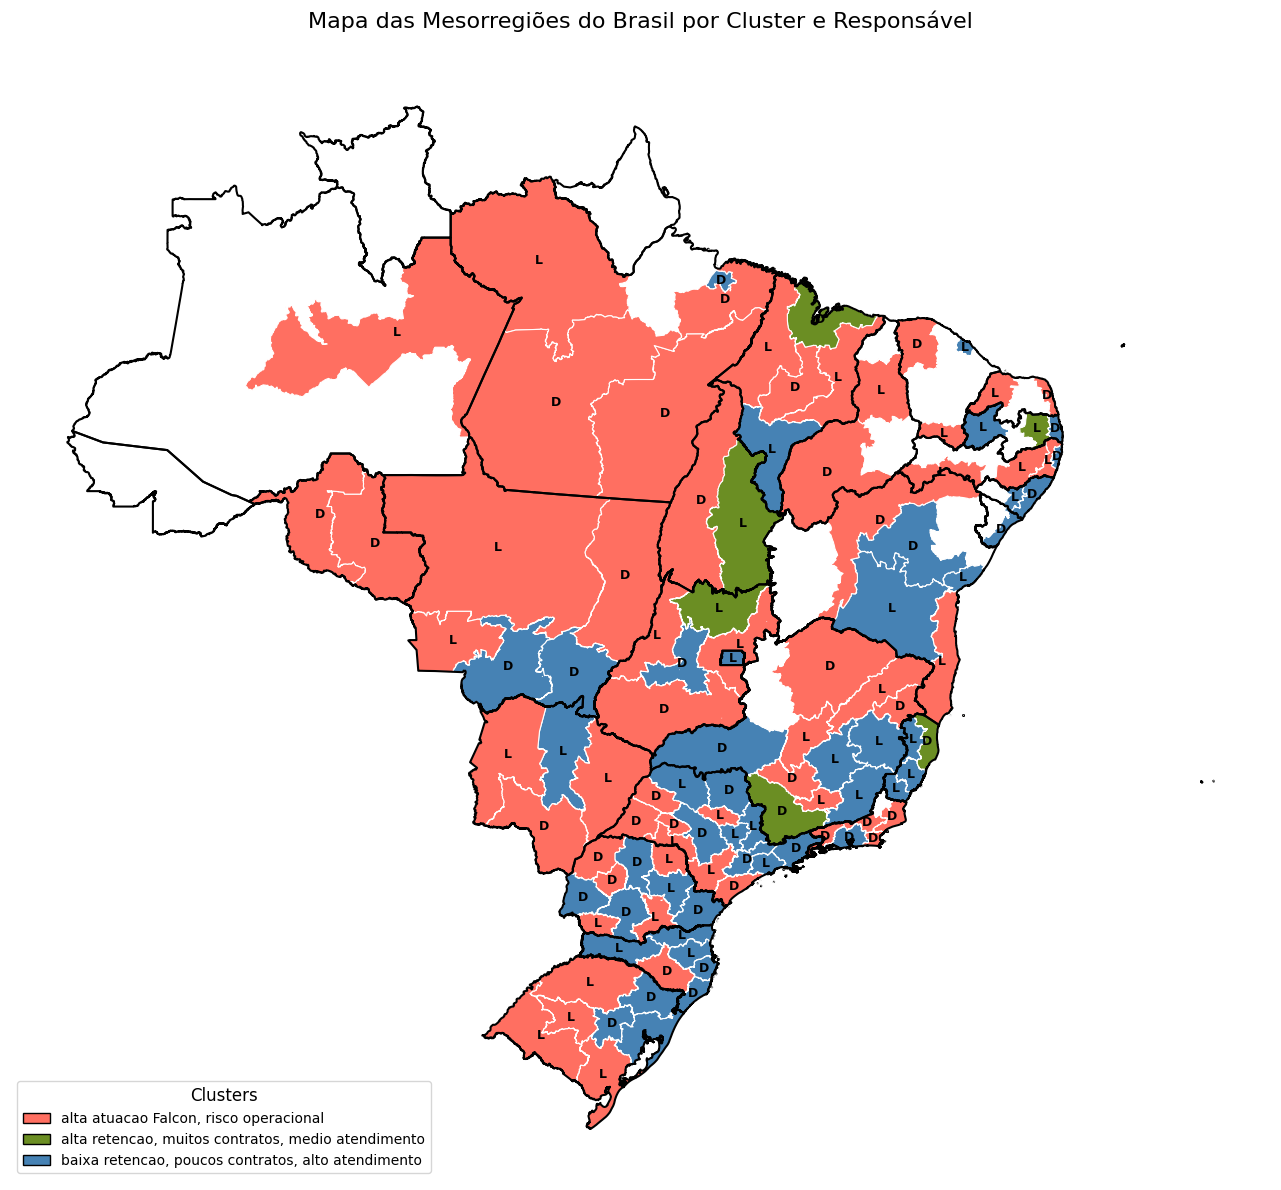

In [46]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from geobr import read_state

# Converter o DataFrame em um GeoDataFrame usando a coluna correta de geometria
distribuindo = gpd.GeoDataFrame(grafico_divisao, geometry='geometry_meso')

# Definir uma paleta de cores mais harmoniosa para os clusters
cores_clusters = {
    'alta atuacao Falcon, risco operacional': '#FF6F61',  # Vermelho suave
    'alta retencao, muitos contratos, medio atendimento': '#6B8E23',  # Verde oliva
    'baixa retencao, poucos contratos, alto atendimento': '#4682B4'  # Azul suave
}

# Mapear as cores no DataFrame
distribuindo['cor_cluster'] = distribuindo['cluster_nomeado'].map(cores_clusters)

# Carregar o contorno dos estados do Brasil usando geobr
states_gdf = read_state(year=2020)

# Criar o mapa
fig, ax = plt.subplots(figsize=(14, 12))

# Plotar as mesorregiões coloridas pelo cluster com contorno branco
distribuindo.plot(
    ax=ax, 
    color=distribuindo['cor_cluster'], 
    edgecolor='white', 
    linewidth=0.8,
    zorder=2  # Mesorregiões em camada inferior ao contorno do Brasil
)

# Adicionar as letras dos responsáveis (D/L) no centro das mesorregiões
for idx, row in distribuindo.iterrows():
    if row['geometry_meso'].centroid.is_valid:
        plt.text(
            row['geometry_meso'].centroid.x, 
            row['geometry_meso'].centroid.y, 
            row['responsavel'],
            fontsize=9,
            ha='center', 
            va='center',
            color='black',
            fontweight='bold',
            zorder=3  # Garantir que o texto fique acima do mapa
        )

# Adicionar o contorno do Brasil e dos estados com destaque
states_gdf.boundary.plot(ax=ax, color='black', linewidth=1.5, zorder=4)

# Criar uma legenda personalizada para os clusters
legendas = [
    Patch(facecolor=color, edgecolor='k', label=label) 
    for label, color in cores_clusters.items()
]

# Exibir a legenda no mapa
plt.legend(handles=legendas, title='Clusters', loc='lower left', fontsize=10, title_fontsize=12)

# Título e ajustes
plt.title('Mapa das Mesorregiões do Brasil por Cluster e Responsável', fontsize=16, pad=20)
plt.axis('off')

# Melhorar o layout do mapa
plt.tight_layout()

# Exibir o mapa final
plt.show()


# CENÁRIOS OCULTOS

In [20]:
contratos_atendidos_falcon = contratos.loc[contratos.atuacao_falcon == 'sim']
taxa_atendimento_falcon_sim = (
    contratos_atendidos_falcon.groupby(['meso'])['foi_cancelada']
    .apply(lambda x: (x == 'nao').sum() / x.count())
    .reset_index(name='taxa_atendimento_falcon_sim'))
display(taxa_atendimento_falcon_sim)

contratos_nao_atendidos_falcon = contratos.loc[contratos.atuacao_falcon == 'nao']
taxa_atendimento_falcon_nao = (
    contratos_nao_atendidos_falcon.groupby(['meso'])['foi_cancelada']
    .apply(lambda x: (x == 'nao').sum() / x.count())
    .reset_index(name='taxa_atendimento_falcon_nao'))
display(taxa_atendimento_falcon_nao)

,meso,taxa_atendimento_falcon_sim
0,Agreste Alagoano,0.33
1,Agreste Paraibano,0.46
2,Agreste Pernambucano,0.67
3,Araraquara,0.63
4,Araçatuba,0.78
...,...,...
106,Vale do Itajaí,0.76
107,Vale do Mucuri,1.00
108,Vale do Paraíba Paulista,0.82
109,Vale do Rio Doce,0.52


,meso,taxa_atendimento_falcon_nao
0,Agreste Alagoano,0.47
1,Agreste Paraibano,0.50
2,Agreste Pernambucano,0.81
3,Agreste Sergipano,0.00
4,Araraquara,0.54
...,...,...
115,Vale do Itajaí,0.83
116,Vale do Mucuri,0.67
117,Vale do Paraíba Paulista,0.83
118,Vale do Rio Doce,0.72


In [24]:
comparativo = pd.merge(taxa_atendimento_falcon_nao, taxa_atendimento_falcon_sim, on=['meso'], how='left')

comparativo.fillna(0.00, inplace=True)

# Remover linhas onde ambas as colunas são 0.00 (equivalente a NaN original)
comparativo = comparativo[
    ~((comparativo['taxa_atendimento_falcon_nao'] == 0.00) & 
      (comparativo['taxa_atendimento_falcon_sim'] == 0.00))]



comparativo

,meso,taxa_atendimento_falcon_nao,taxa_atendimento_falcon_sim
0,Agreste Alagoano,0.47,0.33
1,Agreste Paraibano,0.50,0.46
2,Agreste Pernambucano,0.81,0.67
4,Araraquara,0.54,0.63
5,Araçatuba,0.85,0.78
...,...,...,...
115,Vale do Itajaí,0.83,0.76
116,Vale do Mucuri,0.67,1.00
117,Vale do Paraíba Paulista,0.83,0.82
118,Vale do Rio Doce,0.72,0.52


In [26]:
from scipy import stats

# Realizar o teste de Wilcoxon (não paramétrico)
w_stat, p_value_wilcoxon = stats.wilcoxon(
    comparativo['taxa_atendimento_falcon_nao'], 
    comparativo['taxa_atendimento_falcon_sim']
)

print(f"Teste de Wilcoxon: Estatística W = {w_stat:.4f}, p-valor = {p_value_wilcoxon:.4f}")

# Interpretar o resultado
if p_value_wilcoxon < 0.05:
    print("Resultado: Existe uma diferença estatisticamente significativa entre os grupos (Teste de Wilcoxon).")
else:
    print("Resultado: Não há diferença estatisticamente significativa entre os grupos (Teste de Wilcoxon).")


Teste de Wilcoxon: Estatística W = 1451.5000, p-valor = 0.0000
Resultado: Existe uma diferença estatisticamente significativa entre os grupos (Teste de Wilcoxon).


In [36]:
# Calcular a média das taxas de atendimento para os grupos Falcon Sim e Falcon Não
media_taxa_atendimento = comparativo[['taxa_atendimento_falcon_nao', 'taxa_atendimento_falcon_sim']].mean()

# Exibir o resultado
print("Média das Taxas de Atendimento:")
print(f"Falcon Não: {media_taxa_atendimento['taxa_atendimento_falcon_nao']:.2f}")
print(f"Falcon Sim: {media_taxa_atendimento['taxa_atendimento_falcon_sim']:.2f}")

# Cálculo da diferença percentual
diferenca_percentual = (media_taxa_atendimento['taxa_atendimento_falcon_nao'] - media_taxa_atendimento['taxa_atendimento_falcon_sim']) / media_taxa_atendimento['taxa_atendimento_falcon_sim'] * 100

# Exibir a mensagem formatada
print(f"As mesorregiões onde não houve atuação do Falcon apresentam taxas de atendimento significativamente maiores,")
print(f"com uma diferença de {diferenca_percentual:.2f}% em relação às regiões onde o Falcon atuou.")

Média das Taxas de Atendimento:
Falcon Não: 0.73
Falcon Sim: 0.62
As mesorregiões onde não houve atuação do Falcon apresentam taxas de atendimento significativamente maiores,
com uma diferença de 19.11% em relação às regiões onde o Falcon atuou.


# GRAFICOS PARA APRESENTAÇÃO

In [39]:

graficos = pd.merge(falcon_meso, ibge_meso, on='meso', how='left')
graficos

,meso,categoria,media_contratos,media_price,geometry_meso,estado
0,Agreste Alagoano,ajudante,4.08,9149.71,"POLYGON ((-36.38936 -9.42538, -36.33942 -9.464...",AL
1,Agreste Alagoano,curta,1.61,2830.67,"POLYGON ((-36.38936 -9.42538, -36.33942 -9.464...",AL
2,Agreste Paraibano,ajudante,8.52,1581.50,"POLYGON ((-35.42241 -7.27272, -35.42200 -7.272...",PB
3,Agreste Paraibano,curta,8.19,2324.46,"POLYGON ((-35.42241 -7.27272, -35.42200 -7.272...",PB
4,Agreste Paraibano,longa,1.40,2106.25,"POLYGON ((-35.42241 -7.27272, -35.42200 -7.272...",PB
...,...,...,...,...,...,...
241,Vale do Rio Doce,curta,2.49,2765.74,"POLYGON ((-42.23596 -19.92573, -42.23600 -19.9...",MG
242,Vale do Rio Doce,longa,7.90,15767.30,"POLYGON ((-42.23596 -19.92573, -42.23600 -19.9...",MG
243,Zona da Mata,ajudante,1.72,378.38,"POLYGON ((-42.17449 -21.13178, -42.17495 -21.1...",MG
244,Zona da Mata,curta,3.44,860.50,"POLYGON ((-42.17449 -21.13178, -42.17495 -21.1...",MG


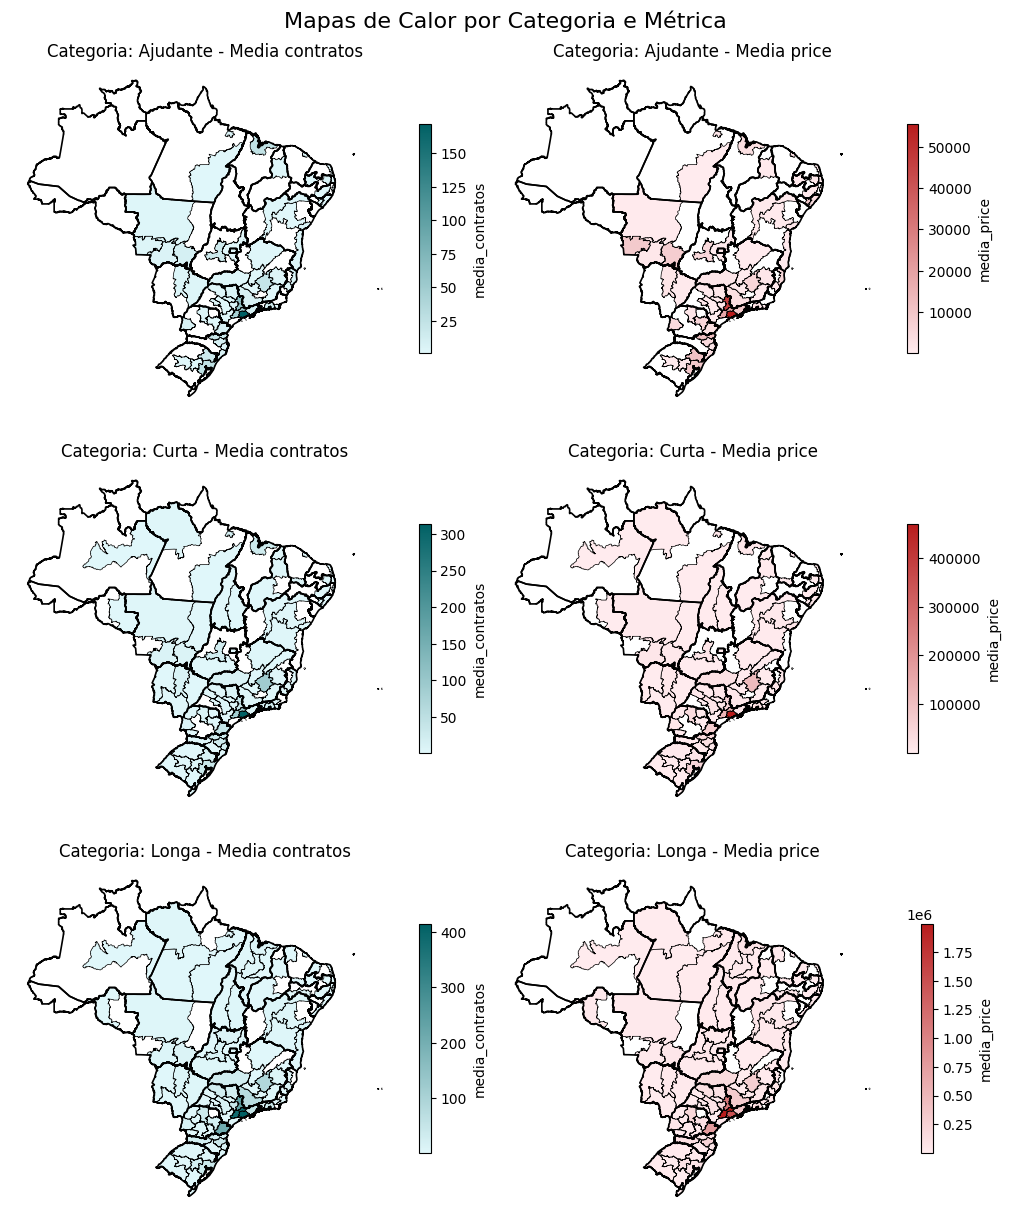

In [49]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from geobr import read_state
from matplotlib.colors import LinearSegmentedColormap

# Carregar o contorno dos estados do Brasil usando geobr
states_gdf = read_state(year=2020)

# Definir categorias e métricas para o mapa de calor
categorias = ['ajudante', 'curta', 'longa']
metricas = ['media_contratos', 'media_price']

# Criar o mapa de calor para cada categoria e métrica
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 12), constrained_layout=True)

# Paleta de cores para os mapas de calor
cmap_contratos = LinearSegmentedColormap.from_list('contratos', ['#e0f7fa', '#006064'])
cmap_price = LinearSegmentedColormap.from_list('price', ['#ffebee', '#b71c1c'])

# Iterar sobre as categorias e métricas para criar os gráficos
for row, categoria in enumerate(categorias):
    for col, metrica in enumerate(metricas):
        ax = axes[row, col]
        
        # Filtrar os dados para a categoria específica
        df_categoria = graficos[graficos['categoria'] == categoria]
        
        # Converter o DataFrame em um GeoDataFrame, assegurando a coluna de geometria
        gdf_categoria = gpd.GeoDataFrame(df_categoria, geometry='geometry_meso')
        
        # Escolher o mapa de cores de acordo com a métrica
        cmap = cmap_contratos if metrica == 'media_contratos' else cmap_price
        
        # Plotar o mapa de calor das mesorregiões
        gdf_categoria.plot(
            ax=ax,
            column=metrica,
            cmap=cmap,
            edgecolor='black',
            linewidth=0.5,
            legend=True,
            legend_kwds={'shrink': 0.6, 'label': f'{metrica}'}
        )
        
        # Adicionar o contorno dos estados brasileiros
        states_gdf.boundary.plot(ax=ax, color='black', linewidth=1.2, zorder=4)
        
        # Título do gráfico
        ax.set_title(f'Categoria: {categoria.capitalize()} - {metrica.replace("_", " ").capitalize()}', fontsize=12)

        # Remover eixos para um visual mais limpo
        ax.set_axis_off()

# Título geral do painel de mapas
fig.suptitle('Mapas de Calor por Categoria e Métrica', fontsize=16, y=1.02)

# Exibir o painel de mapas
plt.show()
